In [1961]:
import os, sys, time, datetime, json, random
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

- 0 - 左
- 1 - 向上
- 2 - 右
- 3 - 向下
- 每次移动都会花费老鼠 -0.04 分
- 奶酪，给予 1.0 分
- 封锁的单元格-0.75 分，动作不会被执行
- 迷宫边界之外的行为：-0.8 分，动作不会被执行
- 已经访问过的单元格，-0.25 分
- 总奖励低于负阈值：(-0.5 * maze.size)，lose

In [2558]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
end_mark = 1
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

maze_path = 'games/GridWorld/maze16_0.05_3.txt'# 'maze8n_4.txt'  # 'games/GridWorld/maze16_0.05_4.txt'  # maze16_0.05_1.txt
ob_size = -1  # -1:全局, N*N
ENV_NAME = 'grid_'+maze_path.split('.txt')[0]

# BATCH_SIZE是指从重放缓冲区采样的转换数
# GAMMA是上一节中提到的折扣系数
# EPS_START是EPSILON的起始值
# EPS_END是epsilon的最终值
# EPS_DECAY 控制epsilon的指数衰减率，越高意味着衰减越慢
# TAU是目标网络的更新率
# LR是AdamW优化器的学习率
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 5e-4 # 5e-4
num_episodes = 1000  # 300
max_Tstep = 512  # 64 128 256
ReplayMemorySize = 1024
sync_target_net_freq = -1  # 1e4 # -1 1e4

R_GOAL = 50
R_WALL = -10
R_MOVE = 0
R_Heuristic = True

Avoid_looping = True

In [2559]:
# now = time.strftime("%m-%d_%H-%M-%S", time.localtime())
# folder_name = f"runs/{ENV_NAME}/" + now
# os.makedirs('runs/', exist_ok=True)
# os.makedirs(f'runs/{ENV_NAME}/', exist_ok=True)
# os.makedirs(folder_name, exist_ok=True)

In [2560]:
import random
import heapq

def find_path(maze, start, end):
    """
    使用 A* 算法搜索迷宫最优路径
    :param maze: 二维迷宫数组，0 表示障碍，1 表示可通行
    :param start: 起点坐标 (row, col)
    :param end: 终点坐标 (row, col)
    :return: 返回最优路径
    """
    ROW, COL = len(maze), len(maze[0])
    pq = []  # 使用优先队列存储搜索节点
    heapq.heappush(pq, (0, start, [start]))
    visited = set()  # 使用 set 存储已访问的节点
    while pq:
        f, (row, col), path = heapq.heappop(pq)
        if (row, col) in visited:
            continue
        visited.add((row, col))
        if (row, col) == end:
            return path
        for (r, c) in [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]:
            if 0 <= r < ROW and 0 <= c < COL and maze[r][c] == 1 and (r, c) not in visited:
                g = len(path)  # 当前节点到起点的距离
                h = abs(r-end[0]) + abs(c-end[1])  # 当前节点到终点的曼哈顿距离
                f = g + h
                heapq.heappush(pq, (f, (r, c), path + [(r, c)]))
    return False

## Q-maze

In [2561]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, ob_size, rat=(0,0), max_Tstep=800):
        # 允许的最大步数
        self.max_Tstep = max_Tstep
        self.action_space = [0, 1, 2, 3]
        # 初始化迷宫，老鼠可以从任意位置开始，默认为左上角
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        # 终点始终在右下角
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        # 初始化空格list，maze为1表示空格，为0表示墙体
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        # 将目标格移出空格list
        self.free_cells.remove(self.target)
        # 检查左上和右下是否为空
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        # 决定观测范围，-1为全局观测
        self.ob_size = ob_size
        # 放置老鼠并初始化参数
        state, info = self.reset(rat)
    
        # return state, info

    def reset(self, rat=(0, 0)):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.maze[self.target[0], self.target[1]] = end_mark
        # 初始状态
        self.state = (row, col, 'start')
        # 设置最低奖励阈值
        self.min_reward = -800 # -0.5 * self.maze.size
        # 初始化总奖励
        self.total_reward = 0
        self.visited = list()
        self.total_Tstep = 0
        
        return self.observe(), self.game_status()

    def update_state(self, action):
        '''
            input: action [0, 1, 2, 3] [L, U, R, D]
        '''
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state
        
        # 如果老鼠访问的是空格，则记录
        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.append((rat_row, rat_col))  # mark visited cell

        # 获取所有可能执行的动作
        valid_actions = self.valid_actions()
        # print('valid_actions', valid_actions)
        
        # 如果没有可以执行的动作（被围住了），则状态为 blocked，位置不变
        if not valid_actions:
            nmode = 'blocked'
            print('blocked')
        # 如果需要执行的动作在可执行动作列表中，那么状态为有效，并相应执行动作
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        # 如果需要执行的动作不在可执行动作列表中（撞墙），位置不变
        else:                  # invalid action, no change in rat position
            nmode = 'invalid'
            
        self.total_Tstep += 1  # 每次执行动作+1
        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        
        reward = 0
        rl = 0
        rg = 0
        
        if rat_row == nrows-1 and rat_col == ncols-1:
            rl = R_GOAL  # 奶酪，给予 1.0 分
        # elif mode == 'blocked':
        #     rl = self.min_reward - 1
        # elif (rat_row, rat_col) in self.visited:
        #     rl = -0.25  # 访问已经访问过的单元格，-0.25 分
        elif mode == 'invalid':
            rl = R_WALL  # 撞墙-0.75 分，动作不会被执行
        elif mode == 'valid':
            rl = R_MOVE  # 每次移动都会花费老鼠 -0.04 分
            
        if R_Heuristic:
            rg = - (abs(self.state[0]-self.target[0]) + abs(self.state[1]-self.target[1]))
#             print(rl, rg)
        
        reward = rl + rg
        
        return reward

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status
    
    def step(self, action):
        envstate, reward, status = self.act(action)
        observation = envstate
        done = self.is_game_done()
        info = status
        return observation, reward, done, info

    def observe(self):
        if self.ob_size == -1:
            canvas = self.draw_env()
        else:
            canvas = self.get_observation()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        canvas[self.target[0], self.target[1]] = end_mark
        return canvas

    def game_status(self):
#         if self.total_Tstep > self.max_Tstep or self.total_reward < self.min_reward:
        # if self.total_reward < self.min_reward:
        if self.total_Tstep > self.max_Tstep:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            self.visited.append((rat_row, rat_col))  # mark visited cell
            return 'win'

        return 'not_over'
    
    def is_game_done(self):
        game_status = self.game_status()
        
        if game_status == 'not_over':
            return False
        elif game_status == 'win' or game_status == 'lose':
            return True
        
        return -1

    def valid_actions(self, cell=None):
        # 默认验证当前位置
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = copy.deepcopy(self.action_space)
        nrows, ncols = self.maze.shape
        # 如果在第0行，则不能向上走；如果在最后一行，则不能向下走
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)
        # 列-左右
        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        # 如果不在最左列，而左边是墙，则不能向左；右边同理
        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        # 上下同理
        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        # 返回所有可能执行的动作
        return actions
    
    def get_observation(self):
        size = self.ob_size
        maze = self.draw_env()
        row, col, _ = self.state
        # 获取maze的行列数
        ROWS = len(maze)
        COLS = len(maze[0])

        # 初始化结果二维数组
        result = [[0 for _ in range(size)] for _ in range(size)]

        # 将以指定点为中心指定尺寸范围的观测值存入结果二维数组
        for i in range(row-size//2, row+size//2+1):
            for j in range(col-size//2, col+size//2+1):
                if i < 0 or i >= ROWS or j < 0 or j >= COLS:
                    # 如果超出边界，则填充为1
                    result[i-row+size//2][j-col+size//2] = 0.0
                else:
                    result[i-row+size//2][j-col+size//2] = maze[i][j]

        # 返回结果二维数组
        result = np.array(result)
        result[size//2][size//2] = 0.5
        return result

In [2562]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [2563]:
# np.savetxt('maze32_1.txt', maze)
# 读取迷宫
maze = np.loadtxt(maze_path)
# maze = maze*0+1.0

optimal path length is: 31
[[0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.

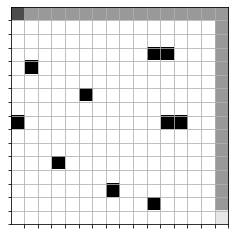

In [2564]:
# 测试读取的迷宫，并获得最优长度optimal_length
qmaze = Qmaze(maze, ob_size=ob_size)
maze_size = maze.shape[0]
optimal_path = find_path(maze, (0, 0), (maze_size-1, maze_size-1))
qmaze.visited = optimal_path
optimal_length = len(optimal_path)

show(qmaze)
print('optimal path length is:', optimal_length)
# 测试观测
print(qmaze.observe())

## DQN

In [2565]:
import math
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, observation_size, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(observation_size, 16*16*2)  # 8*8*2 for global
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(16*16*2, 16*16*2)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(16*16*2, num_actions)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x


In [2566]:
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
# set up matplotliba
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def moving_average(data_list, window_size=100):
    moving_averages = []
    for i in range(len(data_list)):
        if i < window_size:
            window_data = data_list[:i + 1]
        else:
            window_data = data_list[i - window_size + 1:i + 1]
        average = sum(window_data) / len(window_data)
        moving_averages.append(average)
    
    return moving_averages


def plot_rewards(episode_rewards, show_result=False, ylabel='Rewards', window_size=100, maze_size=8):
    plt.figure(1)
    plt.rcParams.update({'font.size': 20})
    # 打开网格
    plt.grid(True)
    rewards_t = np.array(episode_rewards)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(rewards_t)
    
    # Compute the moving average with the specified window size and plot it
    moving_averages = moving_average(episode_rewards, window_size)
    plt.plot(moving_averages)
    
    if ylabel == 'Rewards':
        if maze_size == 16:
            plt.axhline(y=-385, color='Red', linestyle='--')  # 
#             plt.ylim([-385*10, -385*0.8])
#             plt.ylim([-500, 55])
        elif maze_size == 8:
            plt.axhline(y=50, color='Red', linestyle='--')
            plt.ylim([-200, 55])
    if ylabel == 'win_eval':
        plt.ylim([0, 1.1])

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())  # "get current figure"（获取当前图形）
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())



In [2567]:
class Agent():
    def __init__(self, n_observations, LR=LR):
        self.policy_net = DQN(n_observations, num_actions).to(device)
        self.target_net = DQN(n_observations, num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(ReplayMemorySize)
        
        self.sa_feedback_memory_size = 2
        self.sa_feedback_memory = deque(maxlen=self.sa_feedback_memory_size)
#         self.prev_action = None
        self.avoid_looping_status_memory = []
        
        self.steps_done = 0

    # 动作选取
    def select_action(self, state, valid_action, val_mode=False, avoid_looping=False):
    #     global steps_done
        sample = random.random()

        # 随着进行，eps_threshold逐渐降低
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
    #     eps_threshold = 0.1
        if not val_mode:
            self.steps_done += 1

        # 常规情况选择价值最高的动作
        if sample > eps_threshold or val_mode:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.policy_net(state).max(1)[1].view(1, 1)

        # 当随机值超过阈值时，随机选取 - exploration
        else:
            # 探索时只探索可能的动作，增加探索效率？
            action = torch.tensor([[random.choice(valid_action)]], device=device, dtype=torch.long)
        # env.valid_actions()
        
        if avoid_looping:
            self.cur_state = state.cpu().numpy()
            self.cur_action = int(action.cpu()[0][0])
            self.loop_flag = self.is_looping(self.cur_state, self.cur_action)
            self.collision_flag = self.is_continuous_wall_collision(self.cur_state, self.cur_action)
            
            if self.loop_flag or self.collision_flag:
                
                available_actions = [0, 1, 2, 3]
                available_actions.remove(self.cur_action)
                self.new_action = random.choice(available_actions)
                action = torch.tensor([[self.new_action]], device=device, dtype=torch.long)

#             self.prev_action = int(action.cpu()[0][0])
        
        return action
        
#     def choose_different_action(self):
#         available_actions = [0, 1, 2, 3]
#         if self.prev_action is not None and self.prev_action in available_actions:
#             available_actions.remove(self.prev_action)

#         return random.choice(available_actions)
    
    def is_looping(self, cur_state, cur_action):
        if len(self.sa_feedback_memory) < self.sa_feedback_memory_size:
            return False
        
        state0, action0, _ = self.sa_feedback_memory[0]
        state1, action1, _ = self.sa_feedback_memory[1]
        cur_action = [[cur_action]]
        
        if np.array_equal(cur_state, state0) and np.array_equal(cur_action, action0) and self.is_opposite_action(cur_action, action1):
#             print('is_looping')
            return True

    def is_opposite_action(self, cur_action, action1):
        if abs(cur_action[0][0] - action1[0][0])==2:
            return True
        else:
            return False

    def is_continuous_wall_collision(self, cur_state, cur_action):
        if len(self.sa_feedback_memory) < 1:
            return False

        prev_state, prev_action, is_prev_wall_collision1 = self.sa_feedback_memory[-1]
        cur_action = [[cur_action]]
        
#         print('==============================================')
#         print(prev_state)
#         print(cur_state)
#         print(prev_action, cur_action)
#         print(np.array_equal(prev_state, cur_state))
#         print(np.array_equal(prev_action, cur_action))
#         print(is_prev_wall_collision1)

        if np.array_equal(prev_state, cur_state) and np.array_equal(prev_action, cur_action) and is_prev_wall_collision1:
#             print('is_continuous_wall_collision')
            return True
    
    def reset_sa_feedback_memory(self):
        self.sa_feedback_memory.clear()
        self.avoid_looping_status_memory = []
#         self.prev_action = None
    
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        # 离线学习，从记忆池中抽取回忆
        transitions = self.memory.sample(BATCH_SIZE)

        # 将([a, 1], [b, 2], [c, 3])转化为([a, b, c], [1, 2, 3])，一个zip的trick
        # 然后将他们分别放到tuples with names里（'state', 'action', 'next_state', and 'reward'）
        batch = Transition(*zip(*transitions))

        # 计算非最终状态的掩码，并将批处理元素连接起来
        # (最终状态是指模拟结束后的状态)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # 模型计算Q价值，我们根据价值选择动作
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        # 当前奖励+下一个状态的奖励，更新Q. 如果下一个状态为最终状态，则仅有当前奖励(next_state_values是0)
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch  

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
    #     criterion = nn.MSELoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))


    #     print('state_batch', state_batch, state_batch.shape)
    #     print('action_batch', action_batch, action_batch.shape)
    #     print('reward_batch', reward_batch, reward_batch.shape)

    #     print('next_state_values', next_state_values, next_state_values.shape)
    #     print('non_final_mask', non_final_mask, non_final_mask.shape)
    #     print('non_final_next_states', non_final_next_states, non_final_next_states.shape)

    #     print('state_action_values', state_action_values, state_action_values.shape)
    #     print('expected_state_action_values', expected_state_action_values, expected_state_action_values.shape)

    #     raise Exception("Program interrupted!")  # 在这里中断程序

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.item()

    # optimize_model()
    
    def sync_target_net(self):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()

        if sync_target_net_freq > 0:
            if (self.steps_done % sync_target_net_freq) == 0:
                self.target_net.load_state_dict(policy_net_state_dict)
        else:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            self.target_net.load_state_dict(target_net_state_dict)

In [2568]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [2569]:
# ss = []
# es = []
# EPS_DECAY = 10
# for i in range(1000):
#     sample = random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#             math.exp(-1. * i / EPS_DECAY)
#     # eps_threshold = 1.0 / (i + 1)
#     ss.append(sample)
#     es.append(eps_threshold)

# exploit = 0
# for i in range(1000):
#     if ss[i] > es[i]:
#         exploit += 1
# plt.plot(ss)
# plt.plot(es)
# print(exploit, exploit/1000)

In [2570]:
# optimal_length = 86

In [2571]:
from tqdm import trange

status_memory_list = []

def evaluation(agent, show_maze=False, avoid_looping=Avoid_looping):
#     global optimal_length
    optimal_length = 31
    win = 0
    episode_rewards_eval = []
       
    env_eval = Qmaze(maze, ob_size, max_Tstep=86)

    for j in range(1):
    
        # Initialize the environment and get it's state
        state, info = env_eval.reset()
        # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
        state = torch.tensor(state, dtype=torch.float32, device=device)

        done = False
        while not done:
#             action = agent.policy_net(state).max(1)[1].view(1, 1)  # 选择一个动作
            action = agent.select_action(state, None, val_mode=True, avoid_looping=avoid_looping)
            # random.choice(env.valid_actions())
            observation, reward, done, info = env_eval.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
            # reward = torch.tensor([reward], device=device)
            # print(int(action[0][0]))
            # print(observation, reward, done, info)
            # print()
            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

            # Store the transition in memory
#             memory.push(state, action, next_state, reward)
            agent.sa_feedback_memory.append([state.cpu().numpy(), action.cpu().numpy(), is_wall_collision(env_eval, action)])
#             print(agent.sa_feedback_memory)

            if agent.loop_flag:
                agent.avoid_looping_status_memory.append([copy.deepcopy(agent.sa_feedback_memory), 'aviod_looping', agent.cur_action, agent.new_action])
            elif agent.collision_flag:
                agent.avoid_looping_status_memory.append([copy.deepcopy(agent.sa_feedback_memory), 'aviod_wall', agent.cur_action, agent.new_action])
            else:
                agent.avoid_looping_status_memory.append([copy.deepcopy(agent.sa_feedback_memory), 'None', agent.cur_action, agent.cur_action])

            # Move to the next state
            state = next_state
            
            if done:
                status_memory_list.append(copy.deepcopy(agent.avoid_looping_status_memory))
                agent.reset_sa_feedback_memory()
                
        episode_rewards_eval.append(env_eval.total_reward)
        if info == 'win' and env_eval.total_Tstep<=optimal_length:
            win = 1
        elif info == 'win':
            win = 0.5
        else:
            win = 0
    
    
    win_rate = win / 1
    
    if show_maze:
        show(env_eval)
        
    # print(env.visited)
    # print(env.state)
    # print(env.total_reward)
    
    return episode_rewards_eval, win_rate, env_eval.visited

# win_rate = evaluation(10)
# print(win_rate)

In [2572]:
# env = Qmaze(maze, ob_size, max_Tstep=max_Tstep)
# # 重置环境获取信息
# state, info = env.reset()

# n_observations = state.size
# state = torch.Tensor(state).to(device)

# agent = Agent(n_observations)

# evaluation(agent, avoid_looping=True)

# status_memory_list

In [2573]:
def is_wall_collision(env, action):
    return action not in env.valid_actions() 

In [2574]:
history = {}

In [2575]:
from itertools import count

def train():
    

#     steps_done = 0

    # 初始化环境
    env = Qmaze(maze, ob_size, max_Tstep=max_Tstep)
    # 重置环境获取信息
    state, info = env.reset() 

    n_observations = state.size
    state = torch.Tensor(state).to(device)
    
    agent = Agent(n_observations)

    episode_rewards = []
    episode_step = []
    win_eval = []
    loss_train = []
    val_visited_list = []
    episode_rewards_eval_list = []

    #     weights = []
    win_eval_F = []
    val_visited_list_F = []


    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        state, info = env.reset()
        # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
        state = torch.tensor(state, dtype=torch.float32, device=device)

        done = False
        for t in count():
            valid_action = env.valid_actions()
            action = agent.select_action(state, valid_action, avoid_looping=False)  # 选择一个动作 Avoid_looping

            observation, reward, done, _ = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
            reward = torch.tensor([reward], device=device)

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

            # Store the transition in memory
            agent.memory.push(state, action, next_state, reward)
            agent.sa_feedback_memory.append([state.cpu().numpy(), action.cpu().numpy(), is_wall_collision(env, action)])

#             print([state.cpu().numpy(), action.cpu().numpy(), is_wall_collision(env, action)])
        
            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            
            loss = agent.optimize_model()
            if loss is not None:
                loss_train.append(loss)
            

            # Update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            agent.sync_target_net()

            if done:
                agent.reset_sa_feedback_memory()
                break

        episode_rewards_eval, win_rate, val_visited = evaluation(agent, avoid_looping=True)
#         _, win_rate_F, val_visited_F = evaluation(agent, avoid_looping=False)
    #     print('eval_done')
    #     if win_rate == 1:
    #         break

        episode_rewards.append(env.total_reward)
        episode_step.append(t)
        win_eval.append(win_rate)

        episode_rewards_eval_list.append(episode_rewards_eval)
    #     loss_train.append(acc_loss)
    
        val_visited_list.append(val_visited)

        
        history['episode_rewards'] = episode_rewards
        history['episode_step'] = episode_step
        history['win_eval'] = win_eval
        history['loss_train'] = loss_train
        
        history['val_visited_list'] = val_visited_list
        history['episode_rewards_eval_list'] = episode_rewards_eval_list
        
        plot_rewards(episode_step, False, 'Steps')
        
#         win_eval_F.append(win_rate_F)        
#         val_visited_list_F.append(val_visited_F)        
#         history['win_eval_F'] = win_eval_F
#         history['val_visited_list_F'] = val_visited_list_F

        # 将字典保存成 txt 文件
    #     with open(folder_name+'/history.txt', 'w') as f:
    #         for key, value in history.items():
    #             f.write(f'{key}: {value}\n')
    return history

In [2576]:
history_list = []

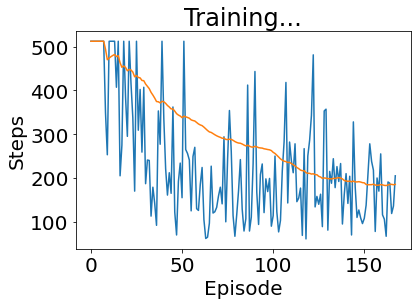

<Figure size 432x288 with 0 Axes>

In [ ]:
for _ in range(1):
    history = train()
    history_list.append(copy.deepcopy(history))

In [2328]:
# history_list.append(copy.deepcopy(history))

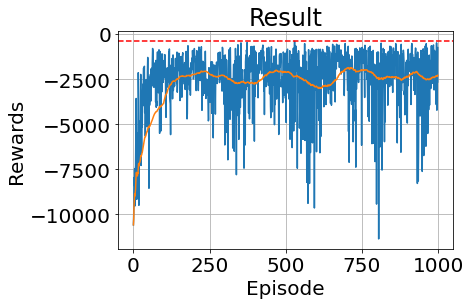

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2578]:
plot_rewards(history_list[0]['episode_rewards'], True, 'Rewards', maze_size=16)

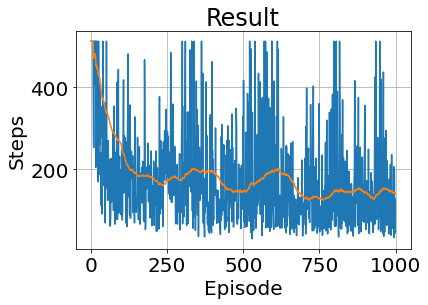

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2579]:
plot_rewards(history_list[0]['episode_step'], True, 'Steps')

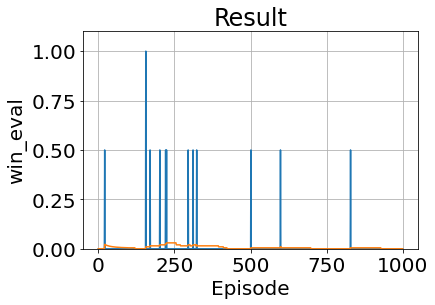

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2580]:
plot_rewards(history_list[0]['win_eval'], True, 'win_eval')

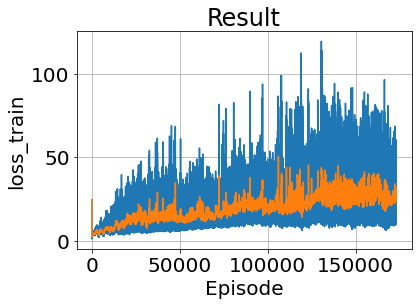

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2581]:
plot_rewards(history_list[0]['loss_train'], True, 'loss_train')

In [2002]:
all_history_list = []

In [2003]:
all_history_list.append(copy.deepcopy(history_list))

In [1987]:
# for i in range(5):
#     all_history_list[1][i]['win_eval'] = all_history_list[0][i]['win_eval']

In [1988]:
# all_history_list[0] = copy.deepcopy(history_list)

In [1989]:
# all_history_list = [all_history_list[0:2]]

In [1990]:
# all_history_list = all_history_list[0]

In [1991]:
# show(env)

In [1992]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 假设5次运行的数据存储在rewards_data中，形状为(num_runs, num_episodes)
# # 您可以使用自己的数据替换这个假设
# num_runs = 5
# num_episodes = 100
# rewards_data = np.random.randn(num_runs, num_episodes)

# # 计算均值和标准差
# mean_rewards = np.mean(rewards_data, axis=0)
# std_rewards = np.std(rewards_data, axis=0)

# # 计算置信区间（这里我们使用1.96倍的标准差，对应于95%置信区间）
# confidence_interval = 1.96 * std_rewards

# # 绘制折线图和置信区间
# episodes = np.arange(1, num_episodes + 1)
# plt.plot(episodes, mean_rewards, label='Mean Rewards')
# plt.fill_between(episodes, mean_rewards - confidence_interval, mean_rewards + confidence_interval, alpha=0.3)

# # 设置图表标题和坐标轴标签
# plt.title('Mean Rewards with Confidence Interval')
# plt.xlabel('Episodes')
# plt.ylabel('Rewards')
# plt.legend()

# # 显示图表
# plt.show()


In [2024]:
num_runs = 3
num_episodes = 300

In [2025]:
# np.random.randn(num_runs, num_episodes)

In [2026]:
import numpy as np
import matplotlib.pyplot as plt

# 定义一个函数来计算均值和90%置信区间
def mean_and_confidence_interval(rewards_data):
    mean_rewards = np.mean(rewards_data, axis=0)
    std_rewards = np.std(rewards_data, axis=0)
    confidence_interval = 1.645 * std_rewards  # 1.645 对应于90%置信区间; 1.96 95%
    return mean_rewards, confidence_interval

# 假设有两个算法的数据，每个算法运行5次，形状为(num_runs, num_episodes)
# 您可以使用自己的数据替换这个假设
# num_runs = 5
# num_episodes = 300

柔和蓝色：'#6CACE4'
柔和橙色：'#F79646'
柔和绿色：'#82B366'
柔和红色：'#E46D76'
柔和黄色：'#F3CC56'
柔和浅蓝：'#89C1C8'
柔和紫罗兰：'#8B81C3'
柔和棕色：'#C1A783'
柔和粉红：'#F4A2A6'
柔和青色：'#7DADD3'

In [2027]:
# all_history_list = all_history_list[0:3]

In [2028]:
len(all_history_list[0])

3

In [2029]:
num_runs

3

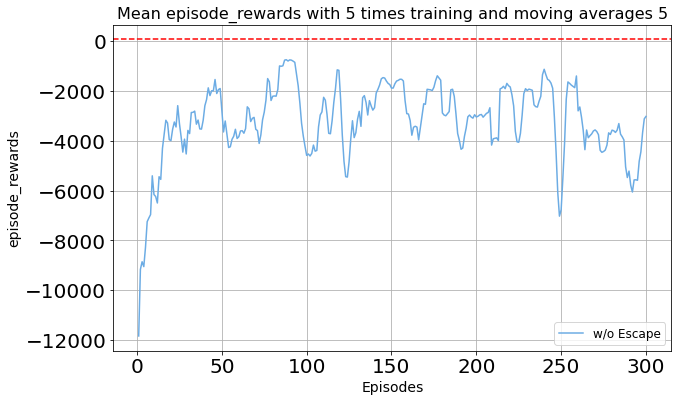

In [2031]:
def plot_conf_map(labels, key, hline=None, y_lim=None, window_size=5):
    # 设置图片大小
    plt.figure(figsize=(10, 6))
    # 打开网格
    plt.grid(True)
    
    color_maps = ['#6CACE4', '#F79646', '#82B366', '#E46D76', '#F3CC56', '#89C1C8']

    for ahl_i in range(len(all_history_list)):
        plot_data_list = []
        for i in range(num_runs):
            plot_data_list.append(all_history_list[ahl_i][i][key])
        plot_data_list = np.array(plot_data_list)

        # 计算两个算法的均值和置信区间
        mean_rewards_algo1, ci_algo1 = mean_and_confidence_interval(plot_data_list)
        # mean_rewards_algo2, ci_algo2 = mean_and_confidence_interval(rewards_data_algo2)



        # 绘制两个算法的折线图和置信区间
        episodes = np.arange(1, num_episodes + 1)
        
        moving_averages_mean_rewards_algo1 = moving_average(mean_rewards_algo1, window_size=window_size) if window_size>0 else mean_rewards_algo1
        plt.plot(episodes, moving_averages_mean_rewards_algo1, label=labels[ahl_i], color=color_maps[ahl_i])
#         plt.fill_between(episodes, mean_rewards_algo1 - ci_algo1, mean_rewards_algo1 + ci_algo1, alpha=0.3, color=color_maps[ahl_i])
    # plt.plot(episodes, mean_rewards_algo2, label='Algorithm 2')
    # plt.fill_between(episodes, mean_rewards_algo2 - ci_algo2, mean_rewards_algo2 + ci_algo2, alpha=0.3)

    if hline is not None:
        plt.axhline(y=hline, color='Red', linestyle='--')
    if y_lim is not None:
        plt.ylim(y_lim)

    # 设置图表标题和坐标轴标签
    plt.title(f'Mean {key} with 3 times training and moving averages {window_size}', fontsize=16)
    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel(key, fontsize=14)
    plt.legend(fontsize=12)

    # 显示图表
    plt.show()

labels = ['From scrach', 'w/ Escape', 'w/ Escape 2']
key = 'episode_rewards'
plot_conf_map(labels, key, hline=50)


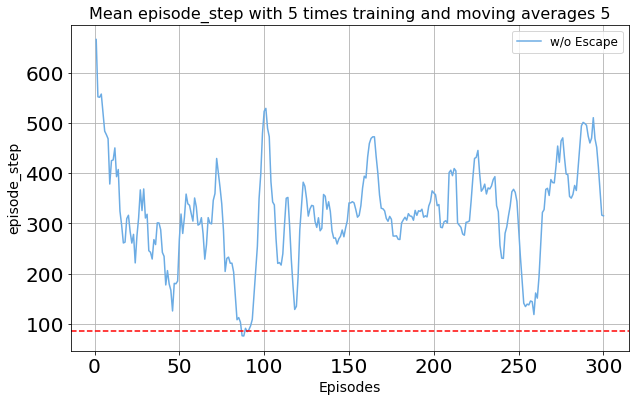

In [2034]:
# labels = ['LR 5e-4', 'LR 1e-4']
key = 'episode_step'

plot_conf_map(labels, key, hline=86)

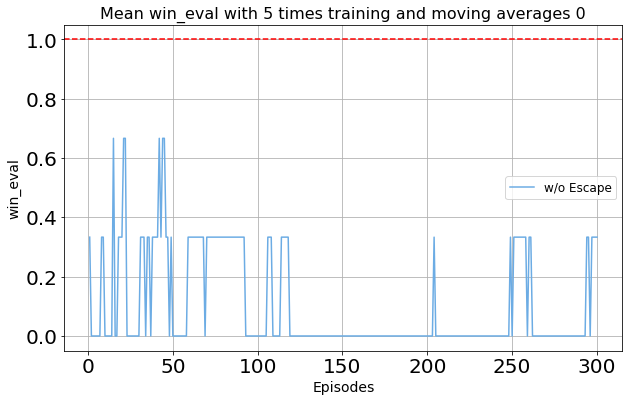

In [2035]:
# labels = ['LR 5e-4', 'LR 1e-4']
key = 'win_eval'

plot_conf_map(labels, key, hline=1, window_size=0)

In [338]:
len(weights[0])

NameError: name 'weights' is not defined

In [778]:
policy_net.parameters

<bound method Module.parameters of DQN(
  (layer1): Linear(in_features=64, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
)>

In [776]:
policy_net.state_dict().keys()

odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'output_layer.weight', 'output_layer.bias'])

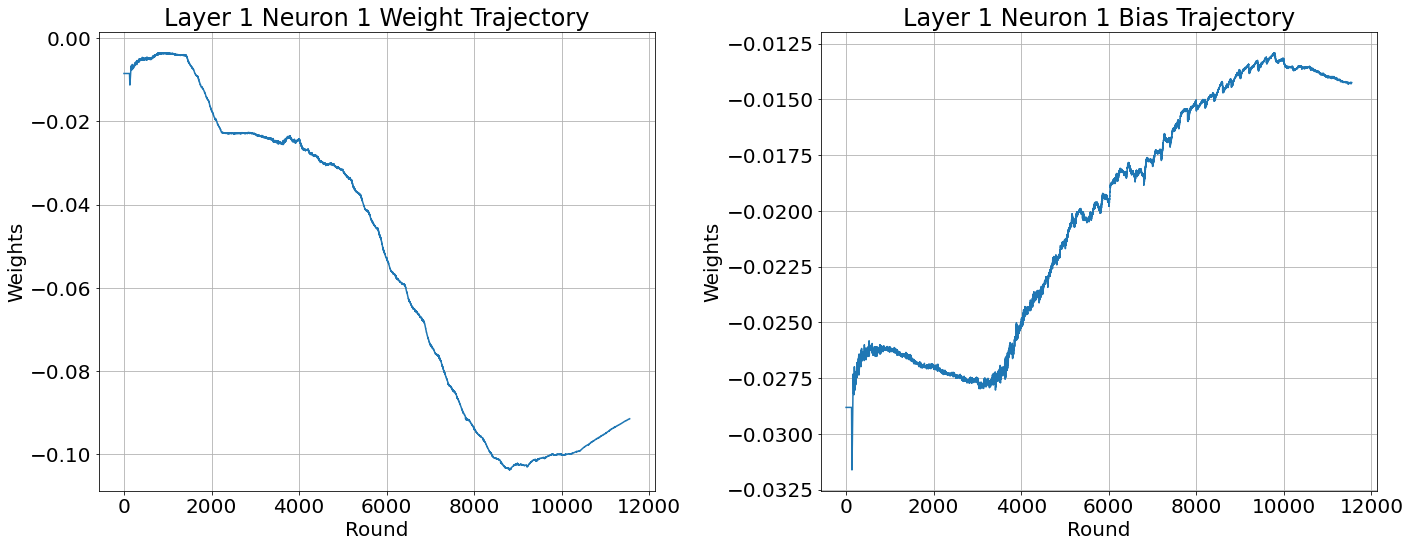

In [796]:
import matplotlib.pyplot as plt

def plot_weights(weights):
    num_layers = len(weights[0])
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    # 设置字体大小为20
    plt.rcParams.update({'font.size': 20})
    
    


    for i in range(2):
        plt.sca(axs[i])
        layer_weights = [w[i] for w in weights]
        axs[i].plot([w.flatten()[0].item() for w in layer_weights])
        axs[i].set_xlabel('Round')
        axs[i].set_ylabel(f'Weights')
        
        
        # 打开网格
        plt.grid(True)
    axs[0].set_title(f'Layer {1} Neuron 1 Weight Trajectory')
    axs[1].set_title(f'Layer {1} Neuron 1 Bias Trajectory')

        

    plt.tight_layout()
    plt.show()

# 用法示例：假设weights是一个包含100轮训练权重的列表
plot_weights(weights)


## 可视化Q值表

In [585]:
maze

array([[1., 1., 0., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1.],
       [1., 0., 1., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1.]])

In [586]:
input_maze = maze.flatten()

In [587]:
input_maze.reshape(1, 64)

array([[1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.]])

In [588]:
input_maze[0] = 0.5
input_maze[-1] = -1

In [589]:
input_maze

array([ 0.5,  1. ,  0. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  0. ,  0. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
        0. ,  0. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  0. ,
        1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  0. ,  1. , -1. ])

In [590]:
def move_p5(arr):
    for i in range(len(arr)):
        if arr[i] == 0.5:
            j = i + 1
            while j < len(arr):
                if arr[j] == 1 or arr[j] == -1:
                    arr[j] = 1.
                    arr[i], arr[j] = arr[j], arr[i]
                    return arr
                else:
                    j += 1

In [591]:
import pandas as pd

# 创建一个行名和列名为指定值的DataFrame，初始值全为0
rows = [(i, j) for i in range(8) for j in range(8)]
cols = ['←', '↑', '→', '↓']
df = pd.DataFrame(0, index=rows, columns=cols)

print(df)

        ←  ↑  →  ↓
(0, 0)  0  0  0  0
(0, 1)  0  0  0  0
(0, 2)  0  0  0  0
(0, 3)  0  0  0  0
(0, 4)  0  0  0  0
...    .. .. .. ..
(7, 3)  0  0  0  0
(7, 4)  0  0  0  0
(7, 5)  0  0  0  0
(7, 6)  0  0  0  0
(7, 7)  0  0  0  0

[64 rows x 4 columns]


In [593]:
while input_maze[-1]==-1:   
    # 获取当前状态
    input_maze_tensor = torch.Tensor(input_maze).cuda()
    
    # 计算当前状态的Q值
    Q_value = policy_net(input_maze_tensor).cpu().detach().numpy()
    index = int(np.where(input_maze==0.5)[0])
    
    # 将array中的值填入(0, 0)行
    df.iloc[index, :] = Q_value
    
    # 移动到下一个状态
    input_maze = move_p5(input_maze)

In [597]:
pd.set_option('display.max_rows', None)

In [598]:
df

,←,↑,→,↓
"(0, 0)",39.887558,40.414181,41.609596,40.861477
"(0, 1)",40.753212,41.114449,41.272713,41.732605
"(0, 2)",0.000000,0.000000,0.000000,0.000000
"(0, 3)",39.751942,40.215618,40.695454,40.785007
"(0, 4)",0.000000,0.000000,0.000000,0.000000
"(0, 5)",40.950951,41.523399,41.991951,41.913960
"(0, 6)",41.933956,42.465855,42.960537,42.680939
"(0, 7)",41.102913,41.710564,41.999268,42.045547
"(1, 0)",39.433727,39.868710,41.348690,40.177315
"(1, 1)",40.910725,41.271641,41.800476,41.668674


In [602]:
max_idx = df.idxmax(axis=1)

np.array(max_idx.to_list()).reshape(8, 8)

array([['→', '↓', '←', '↓', '←', '→', '→', '↓'],
       ['→', '→', '↓', '↓', '↓', '←', '←', '↓'],
       ['↓', '←', '→', '→', '→', '↓', '←', '←'],
       ['←', '→', '→', '→', '→', '→', '→', '↓'],
       ['↓', '↓', '←', '→', '→', '→', '→', '↓'],
       ['←', '↓', '↓', '←', '↓', '←', '→', '↓'],
       ['→', '↓', '←', '→', '→', '→', '→', '↓'],
       ['→', '↓', '←', '↓', '↓', '←', '→', '←']], dtype='<U1')

## 保存训练结果

In [822]:
# EPS_DECAY

In [823]:
# ss = []
# es = []
# # EPS_DECAY = 50000
# for i in range(len(loss_train)):
#     sample = random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#             math.exp(-1. * i / EPS_DECAY)
#     # eps_threshold = 1.0 / (i + 1)
#     ss.append(sample)
#     es.append(eps_threshold)

# exploit = 0
# for i in range(1000):
#     if ss[i] > es[i]:
#         exploit += 1
        
# plt.scatter(list(range(len(ss))), ss, s=0.1)
# plt.plot(es, c='r',linewidth=2)

# print(exploit, exploit/1000)

In [192]:
now = time.strftime("%m-%d_%H-%M-%S", time.localtime())
save_path = f"runs/grid_8_5/{ENV_NAME}_LR1e_5/" + now

In [193]:
os.makedirs(save_path, exist_ok=True)

In [194]:
cfg = {
    'visited_mark': visited_mark,
    'end_mark': end_mark,
    'rat_mark': rat_mark,
    'LEFT': LEFT,
    'UP': UP,
    'RIGHT': RIGHT,
    'DOWN': DOWN,
    'actions_dict': actions_dict,
    'num_actions': num_actions,
    'maze_path': maze_path,
    'ob_size': ob_size,
    'ENV_NAME': ENV_NAME,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'EPS_START': EPS_START,
    'EPS_END': EPS_END,
    'EPS_DECAY': EPS_DECAY,
    'TAU': TAU,
    'LR': LR,
    'num_episodes': num_episodes,
    'max_Tstep': max_Tstep,
    'sync_target_net_freq': sync_target_net_freq,
    'R_GOAL': R_GOAL,
    'R_WALL': R_WALL,
    'R_MOVE': R_MOVE,
    'R_Heuristic': R_Heuristic,
}

In [195]:
# 将字典保存成 txt 文件
with open(save_path+'/config.txt', 'w') as f:
    for key, value in cfg.items():
        f.write(f'{key}: {value}\n')

In [196]:
# 将字典保存成 txt 文件
for i in range(len(history_list)):
    with open(save_path+'/history'+ str(i) +'.txt', 'w') as f:
        for key, value in history_list[i].items():
            f.write(f'{key}: {value}\n')

In [197]:
print(cfg)

{'visited_mark': 0.8, 'end_mark': -1, 'rat_mark': 0.5, 'LEFT': 0, 'UP': 1, 'RIGHT': 2, 'DOWN': 3, 'actions_dict': {0: 'left', 1: 'up', 2: 'right', 3: 'down'}, 'num_actions': 4, 'maze_path': 'maze8n_4.txt', 'ob_size': -1, 'ENV_NAME': 'grid_maze8n_4', 'BATCH_SIZE': 128, 'GAMMA': 0.99, 'EPS_START': 0.95, 'EPS_END': 0.05, 'EPS_DECAY': 20000, 'TAU': 0.005, 'LR': 1e-05, 'num_episodes': 300, 'max_Tstep': 128, 'sync_target_net_freq': 200, 'R_GOAL': 50, 'R_WALL': -10, 'R_MOVE': 0, 'R_Heuristic': False}


## 可视化路径

In [2503]:
def visualize_path(maze, path):
    maze_size = len(maze)
    plt.figure(figsize=(maze_size/2, maze_size/2))

    # Draw obstacles
    for i in range(maze_size):
        for j in range(maze_size):
            if maze[i][j] == 0:
                plt.fill_between([j-.5, j+1-.5], i-.5, i+1-.5, color='black')

    # Draw the path
    for index, position in enumerate(path[:-1]):
        plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color='blue', linewidth=2)

    plt.plot(0, 0, 'go', markersize=10, label='Start')  # start point
    plt.plot(maze_size - 1, maze_size - 1, 'ro', markersize=10, label='Goal')  # goal point
#     plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()


In [2504]:
win_eval = history_list[0]['win_eval']

In [2505]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value == 1]

print(indices_of_ones)

[170]


In [2506]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value > 0 and value < 1]

print(indices_of_ones)

[71, 157, 194, 199, 212, 214, 282]


In [2507]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value == 0]

print(indices_of_ones)
print(len(indices_of_ones))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228

In [2514]:
index = 298

In [2515]:
path = history_list[0]['val_visited_list_F'][index]
print(path)

# maze_size = 8
print("Steps:", len(path))
visualize_path(maze, path)
path_F = path

KeyError: 'val_visited_list_F'

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 0), (6, 0), (7, 0), (7, 0), (6, 0), (7, 0), (7, 0), (7, 0), (7, 0), (6, 0), (7, 0), (7, 0), (6, 0), (7, 0), (7, 0), (7, 0), (7, 0), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (15, 1), (14, 1), (15, 1), (15, 1), (15, 2), (15, 2), (15, 3), (15, 3), (15, 2), (15, 2), (14, 2), (15, 2), (15, 2), (15, 3), (15, 3), (15, 4), (15, 4), (15, 3), (15, 3), (15, 4), (15, 4), (14, 4), (15, 4), (15, 4), (15, 3), (15, 3), (14, 3), (15, 3), (15, 3), (14, 3), (15, 3), (15, 3), (15, 2), (15, 2), (15, 1), (15, 1), (15, 0), (15, 0), (15, 1), (15, 1), (15, 0), (15, 0), (15, 0), (15, 0), (15, 0), (15, 0), (15, 1), (15, 1), (14, 1), (15, 1), (15, 1), (15, 2), (15, 2)]
Steps: 87


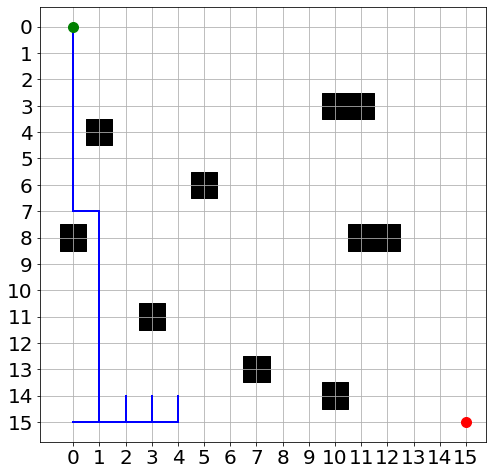

In [2516]:
path = history_list[0]['val_visited_list'][index]
print(path)

# maze_size = 8
print("Steps:", len(path))
visualize_path(maze, path)

In [2517]:
for i in range(len(path)-2):
    print(f"path: {path[i]}\tstatus_memory_list: {status_memory_list[index][i][1:]}")

path: (0, 0)	status_memory_list: ['None', 2, 2]
path: (1, 0)	status_memory_list: ['None', 2, 2]
path: (2, 0)	status_memory_list: ['None', 2, 2]
path: (3, 0)	status_memory_list: ['None', 2, 2]
path: (4, 0)	status_memory_list: ['None', 2, 2]
path: (5, 0)	status_memory_list: ['None', 2, 2]
path: (6, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (6, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (6, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['aviod_wall', 2, 0]
path: (6, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['None', 2, 2]
path: (7, 0)	status_memory_list: ['aviod_wall', 2, 1]
path: (6, 0)	status_memory_l

In [2295]:
for i in range(len(path)-1):
    print(f"path_F: {path_F[i]}\tpath: {path[i]}\tstatus_memory_list: {status_memory_list[index*2][i][1:]}")

IndexError: list index out of range

In [2296]:
len(status_memory_list)

300

In [1062]:
status_memory_list[index][7]

[deque([[array([[ 1. ,  1. ,  0. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
                  1. ,  1. ,  0. ,  0. ,  1. ,  0.5,  0. ,  1. ,  1. ,  1. ,  1. ,
                  0. ,  0. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
                  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  0. ,
                  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
                  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  0. ,  1. , -1. ]],
               dtype=float32),
         array([[1]]),
         False],
        [array([[ 1. ,  1. ,  0. ,  1. ,  0. ,  1. ,  1. ,  1. ,  0.5,  1. ,  1. ,
                  1. ,  1. ,  0. ,  0. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
                  0. ,  0. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
                  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  0. ,
                  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
                  1. ,  1.

In [1032]:
print(path_F, path, status_memory_list[index])

[(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (3, 4), (3, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5)] [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (3, 4), (3, 5), (4, 5), (4, 5), (4, 6), (4, 7), (5, 7), (5, 7), (6, 7), (7, 7), (7, 7)] [[deque([[array([[ 0.5,  1. ,  0. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
         1. ,  1. ,  0. ,  0. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
         0. ,  0. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
         1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  0. ,
         1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
         1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  0. ,  1. , -1. ]],
      dtype=float32), array([[3]]), False]], maxlen=2), 'None', 3, 3], [deque([[array([[ 0.5,  1. ,  0. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
         1. ,  1. ,  0. ,  0. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,
         0. , 

## 手动测试

In [2398]:
def test_():

    # Initialize the environment and get it's state
    state, info = env.reset()
    # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
    state = torch.tensor(state, dtype=torch.float32, device=device)

    env.max_Tstep = 86

    done = False
    while not done:
    #     print(state)
#         action = policy_net(state).max(1)[1].view(1, 1).item()  # 选择一个动作
#         action = random.choice(env.valid_actions())
#         action = random.choice(env.action_space)
        action = random.choice([0, 1, 2, 3])
        observation, reward, done, info = env.step(action)  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
        # reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

        # Store the transition in memory
        # memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

    return info
    

In [2400]:
win_rate = 0
for i in trange(1000):
    info = test_()
    if info == 'win':
        win_rate += 1

print(win_rate/1000)

100%|██████████| 1000/1000 [00:06<00:00, 161.83it/s]

0.097


In [954]:
# 智能随机
# 256 0.591
# 128 0.323

# 完全随机
# 256 0.433
# 128 0.194


In [955]:
env.valid_actions()

[0, 1, 3]

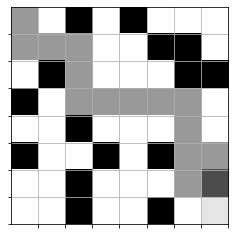

In [956]:
show(env)

In [857]:
env.max_Tstep

128

In [610]:
# show(env)
# print(env.visited)
# print(env.total_reward)